# Signal processing
Here, we'll demonstrate how you could implement common signal processing techniques for neuroscience data using Python. Along the way, we'll explore a few useful tools for dealing with time series data, particularly EEG and ECoG data.

### By the end of this notebook, you'll be able to:
* Demonstrate how we can add sine waves to create complex waveforms
* Apply a fourier transform to your data
* Filter data by frequency bandwidths of interest
* Use Welch's method to create a power spectral density plot

First, let's get setup...

In [2]:
# All of the lovely packages we need for today
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

## Part I: Simple sine waves

Let's first generate a sine wave. We'll then generate a second sine wave and add these together to understand what a fourier transform of this data would look like. **Sine waves** are defined by their frequency, ampltitude, and and phase.

In [3]:
f     = 1024 # Sampling frequency
dur   = 1    # 1 second of signal
freq  = 7    # 7 Hz signal
freq2 = 130  # 130 Hz signal

t = np.arange(0, dur, 1/f) # Generate a time vector

sig1 = np.sin(2 * np.pi * freq * t) # Generate a sine wave
sig1 = 2 * sig1                     # Increase the power of signal 1

sig1s = np.sin(np.pi + 2 * np.pi * freq * t) # Generate a sine wave
sig1s = 2 * sig1s                     # Increase the power of signal 1

sig2 = np.sin(2 * np.pi * freq2 * t) # Generate another sine wave

sig3 = 3*np.random.standard_normal(len(t)) # Generate a noisy signal


Plot our sine waves.

<div class="alert alert-success">
<b>Task</b>:

1. Add the two sine waves together, to create a third signal `combined_signal`.
2. Plot this signal.
    
</div>

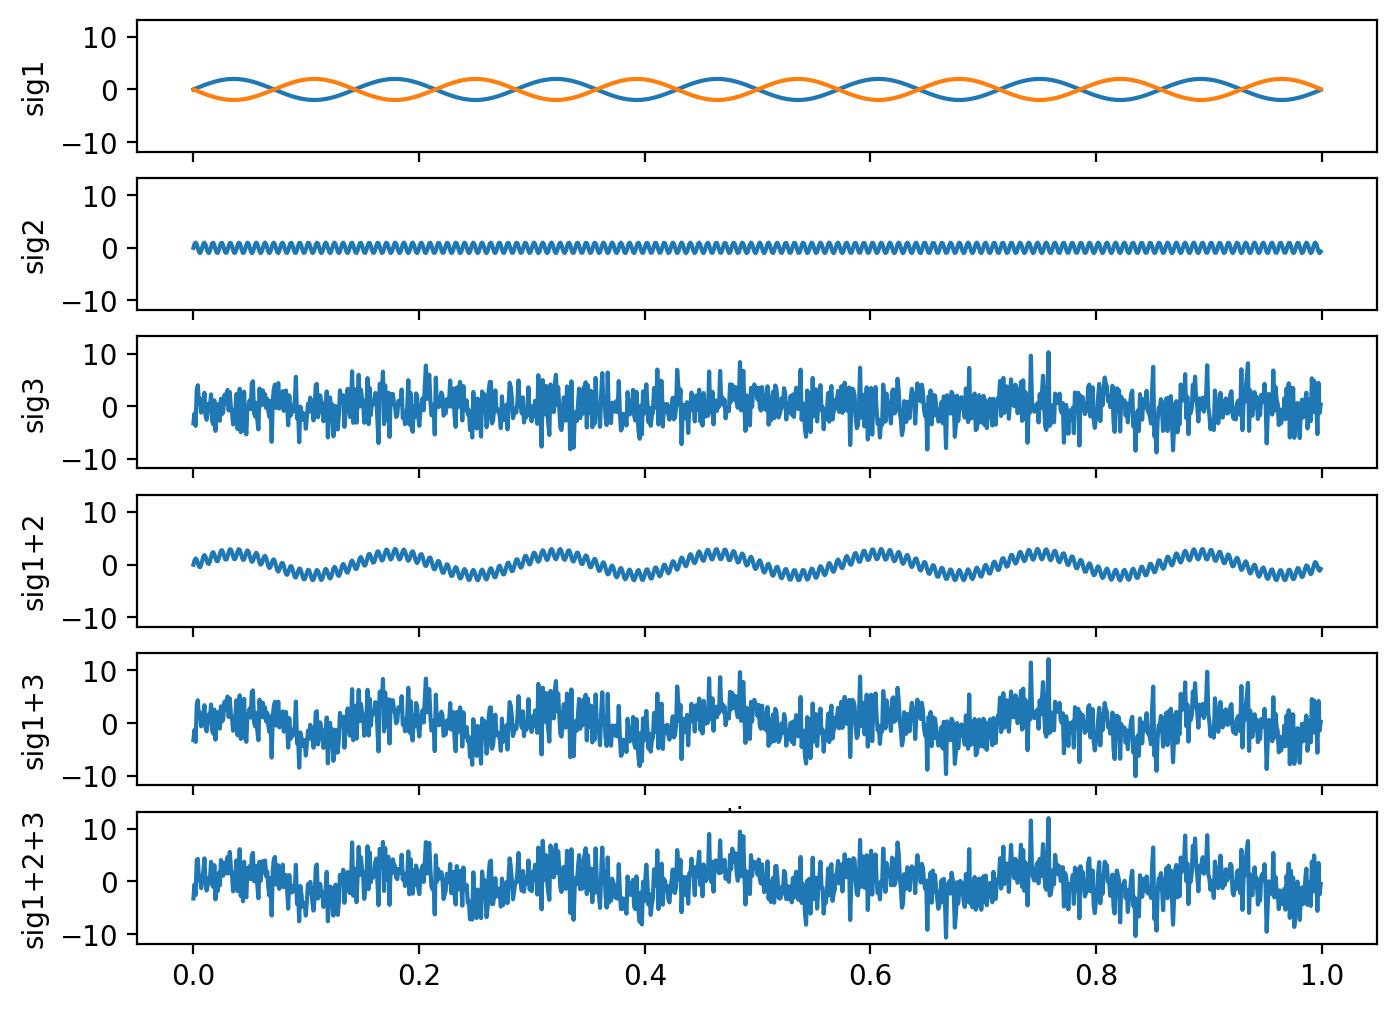

In [17]:
# Add signal 1 & 2

comb_sig_12  = sig1 + sig2
comb_sig_13  = sig1 + sig3
comb_sig_123 = sig1 + sig2 + sig3
comb_sig_1s2  = sig1s + sig2


# Plot
fig , ax = plt.subplots(6,1,figsize = (8,6),sharex=True,sharey=True)
ax[0].plot(t,sig1)
ax[0].plot(t,sig1s)

ax[1].plot(t,sig2)
ax[2].plot(t,sig3)
ax[3].plot(t,comb_sig_12)
ax[4].plot(t,comb_sig_13)
ax[5].plot(t,comb_sig_123)


ax[4].set_xlabel('time')
ax[0].set_ylabel('sig1')
ax[1].set_ylabel('sig2')
ax[2].set_ylabel('sig3')
ax[3].set_ylabel('sig1+2')
ax[4].set_ylabel('sig1+3')
ax[5].set_ylabel('sig1+2+3')
plt.show()

Below, we'll calculate the **Fourier Transform** using the fast fourier transform package from numpy. The fft (developed by Tukey -- same Tukey as the statistics Tukey -- in 1965) implements a _discrete_ Fourier transform for a digital signal.

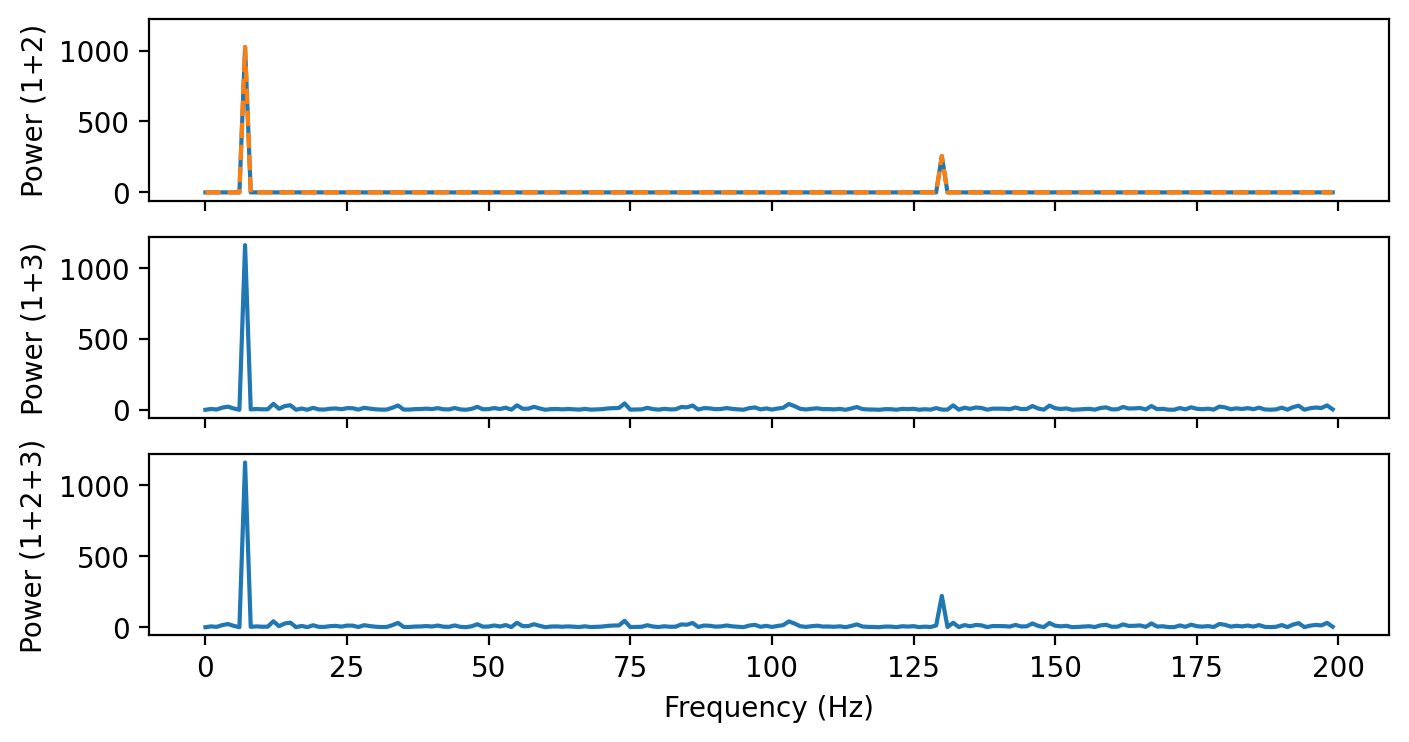

[2560.0, 11116.065426450965, 11554.534734855735]
[2560.0, 11116.065426450963, 11554.534734855735]


In [18]:
# Calculate the fourier transform of complex signal
fourier_12  = np.fft.fft(comb_sig_12)/len(t)*np.sqrt(f)  # Compute the fft, normalized by time and sqrt of sampling frequency
fourier_13  = np.fft.fft(comb_sig_13)/len(t)*np.sqrt(f)  # Compute the fft, normalized by time and sqrt of sampling frequency
fourier_123 = np.fft.fft(comb_sig_123)/len(t)*np.sqrt(f) # Compute the fft, normalized by time and sqrt of sampling frequency
fourier_1s2  = np.fft.fft(comb_sig_1s2)/len(t)*np.sqrt(f)  # Compute the fft, normalized by time and sqrt of sampling frequency

# Find frequency values for the x axis
nyq = f/2 # Determine the nyquist frequency

# Create freq bins for plotting by creating a vector from 0 to nyquist
# with as many points as in fft
fx_bins = np.linspace(0,nyq,int(np.floor(len(sig1)/2))+1)

fig , ax = plt.subplots(3,1,figsize = (8,4),sharex=True,sharey=True)

# Plotting up to 200 Hz
ax[0].plot(fx_bins[0:200],np.power(abs(fourier_12[0:200]),2)) # Plot a select range of frequencies
ax[0].plot(fx_bins[0:200],np.power(abs(fourier_1s2[0:200]),2),'--') # Plot a select range of frequencies
ax[1].plot(fx_bins[0:200],np.power(abs(fourier_13[0:200]),2)) # Plot a select range of frequencies
ax[2].plot(fx_bins[0:200],np.power(abs(fourier_123[0:200]),2)) # Plot a select range of frequencies
ax[0].set_ylabel('Power (1+2)')
ax[1].set_ylabel('Power (1+3)')
ax[2].set_ylabel('Power (1+2+3)')
ax[2].set_xlabel('Frequency (Hz)')
# plt.title('FFT of a complex signal')
plt.show()

power_fourier = [np.sum(np.power(abs(fourier_12),2)) , np.sum(np.power(abs(fourier_13),2)) , np.sum(np.power(abs(fourier_123),2)) ] 
power_orig    = [np.sum(np.power(abs(comb_sig_12),2)), np.sum(np.power(abs(comb_sig_13),2)), np.sum(np.power(abs(comb_sig_123),2))] 
print(power_fourier)
print(power_orig)

Text(0, 0.5, 'imaginary part')

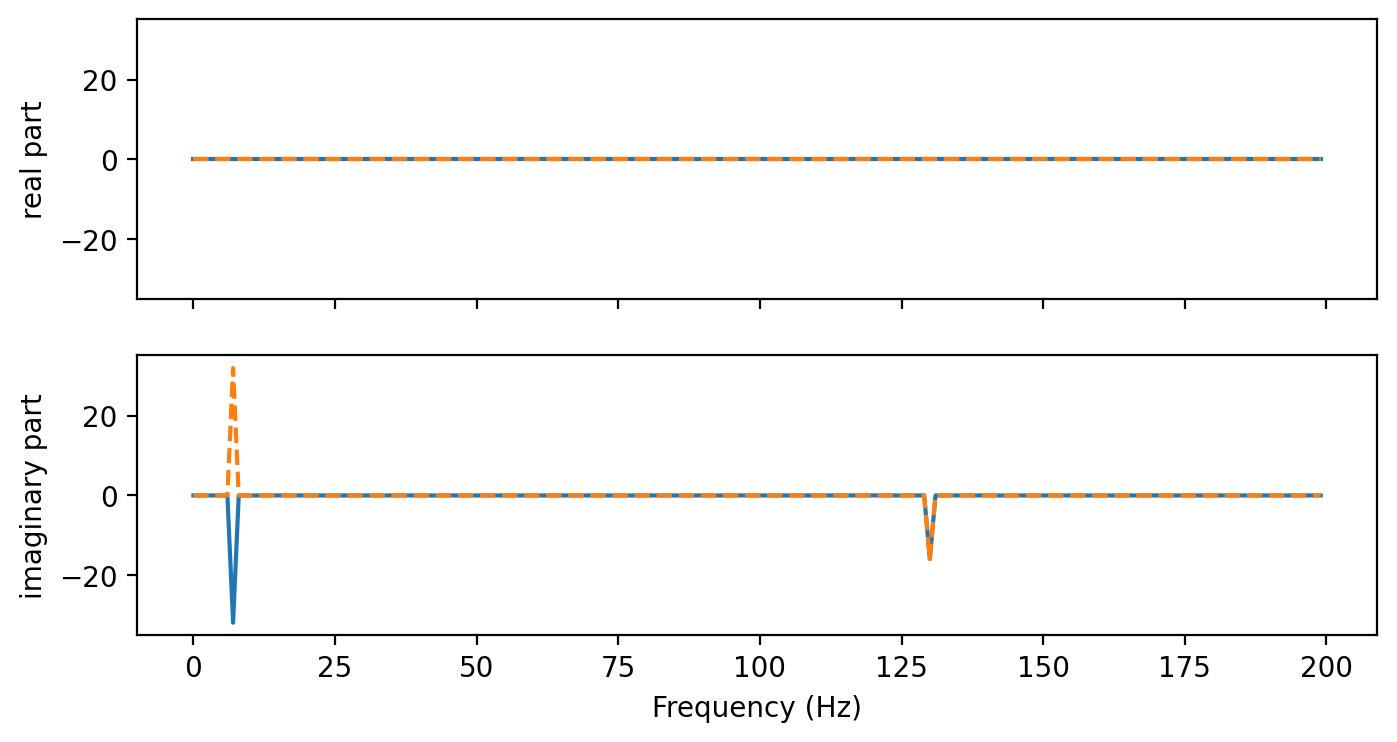

In [22]:
fig , ax = plt.subplots(2,1,figsize = (8,4),sharex=True,sharey=True)
ax[0].plot(fx_bins[0:200],np.real(fourier_12[0:200])) # Plot a select range of frequencies
ax[0].plot(fx_bins[0:200],np.real(fourier_1s2[0:200]),'--') # Plot a select range of frequencies
ax[1].plot(fx_bins[0:200],np.imag(fourier_12[0:200])) # Plot a select range of frequencies
ax[1].plot(fx_bins[0:200],np.imag(fourier_1s2[0:200]),'--') # Plot a select range of frequencies
ax[1].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('real part')
ax[1].set_ylabel('imaginary part')

**Note**: As Pascal Wallisch & Eric Nylen have written: "Frequency space is a place of _magic and wonder_." The Fourier transform of a time series usually involves complex numbers with imaginary parts. If we plot the Fourier transform itself by typing `plt.plot(fourier)`, it will yield a funky plot. That’s because the complex numbers represent both magnitude and phase at once, but we are _only interested in amplitude or power_ at this point, which is why we plotted only the absolute values above. Also, if you type `plt.plot(abs(fourier))`, you will get a plot of all the magnitudes, but note that it is mirror-symmetric in the middle—it repeats after half the sampling rate.

## Step 2. Import and filter real sleep data.

Normal physiological data is never as regular as the data above -- it's usually chock full of lots of different waves, as well as noise. Now that we have a sense of the tools we need, let's work with some real data.

The data we'll import here is a real 30-seconds extract of slow-wave sleep from a young individual, collected by the Walker Lab at UC Berkeley. This data was collected at 100 Hz from channel 'F3'. This sampling frequency is fine for EEG data, but wouldn't be enough for high frequency spiking data. That kind of data is typically sampled at 40 **kilo**Hz.

In [23]:
import urllib.request

# URL of data to download
data_url = 'https://raphaelvallat.com/images/tutorials/bandpower/data.txt'

# Get the data and save it as "sleep_data.txt"
sleep_data, headers = urllib.request.urlretrieve(data_url, './sleep_data.txt')

<div class="alert alert-success">
    <b>Task</b>: Using a numpy function we've already learned, load your text file and assign it to "data". 

(3000,)


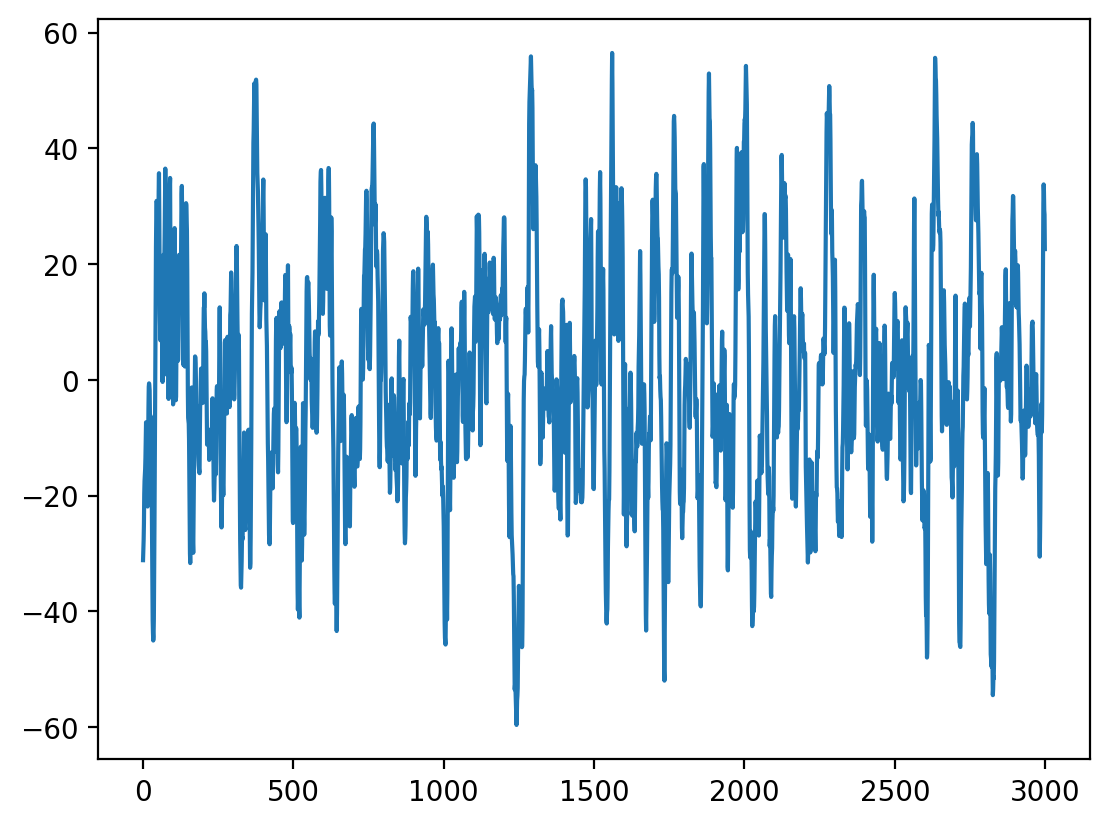

In [24]:
# Load the .txt file
data = np.loadtxt(fname='sleep_data.txt', delimiter=',')
print(data.shape)
plt.plot(data)
plt.show()

First, we'll plot the raw data. The data provides the information about voltage for the y axis. However, we need to also create a time vector, so that we can accurately label the x axis. The `np.arange()` method is very useful for this. We need to create a vector that is the same length as our data, but where each number is in terms of **time**, not **samples**. To do so, we'll divide our vector by the sampling rate.

<div class="alert alert-success">

**Task**: Create a `time_vector` variable so that your data is plotted in seconds, not samples.

</div>

In [25]:
# Define sampling frequency, num_samples, and time vector
sampling_freq = 100 # sampling frequency, in Hz
num_samples   = data.size
time_vector   = np.arange(0,num_samples/sampling_freq,1/sampling_freq)
time_vector.shape
print(time_vector[1]-time_vector[0])

0.01


<div class="alert alert-success">

**Task**: Plot your signal! You only need to add a line of code where it says `# ADD CODE HERE`

</div>

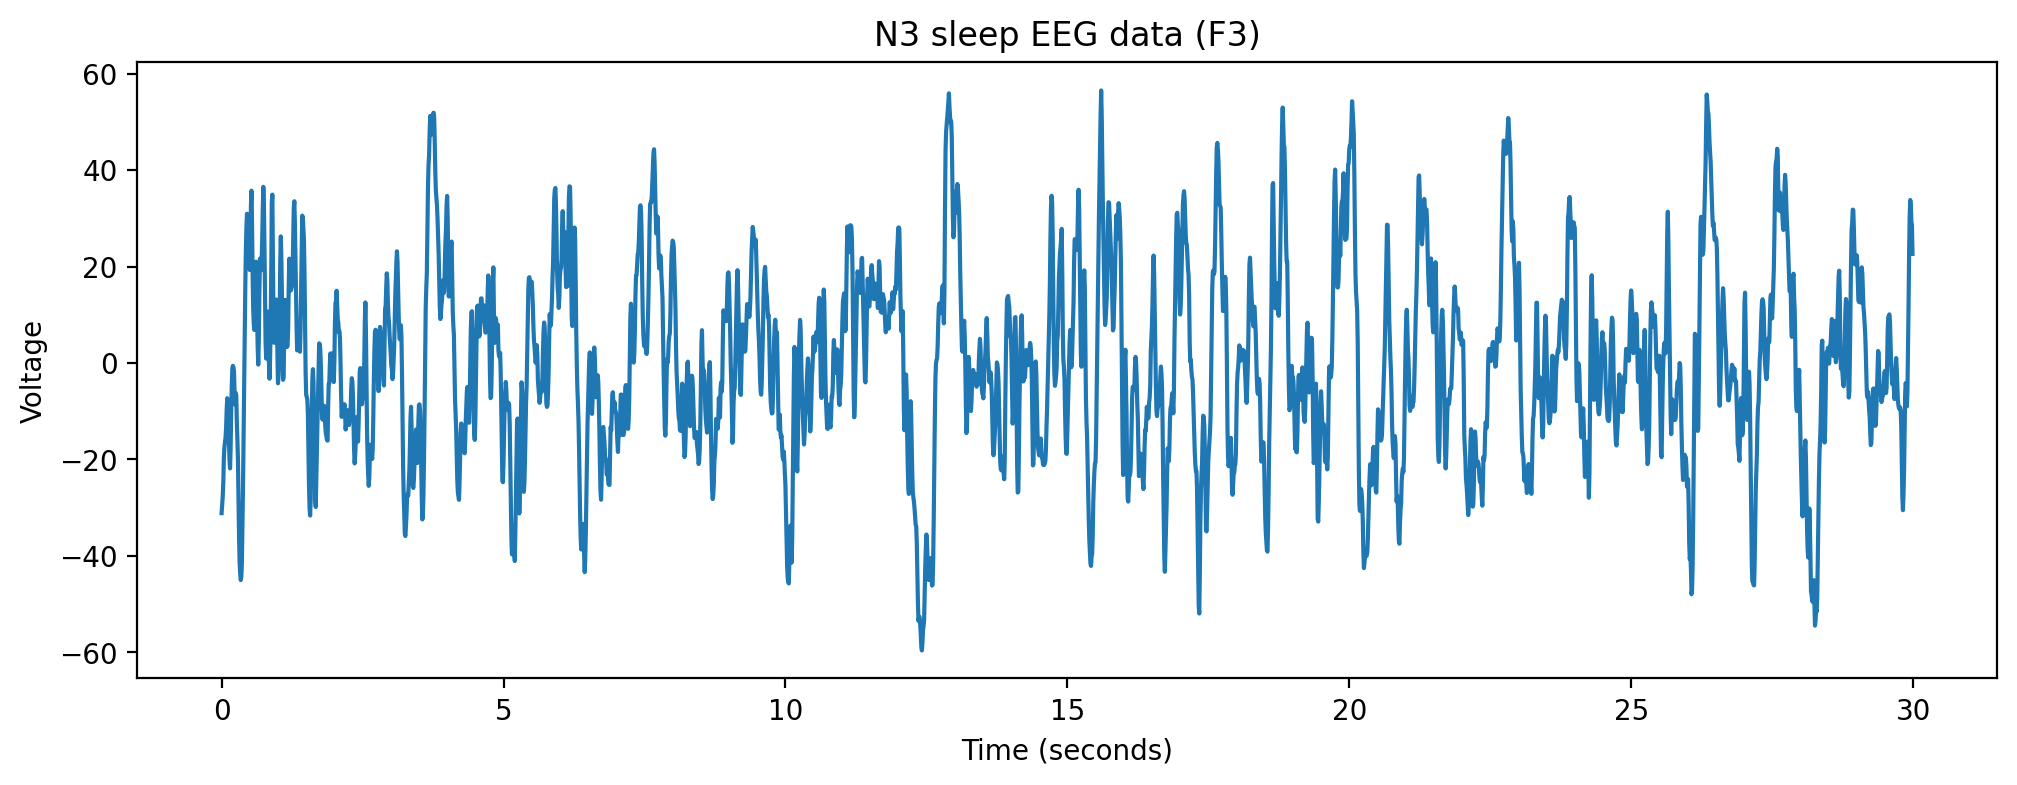

In [26]:
# Plot the signal
fig, ax = plt.subplots(figsize=(12, 4))

# ADD CODE HERE
plt.plot(time_vector,data,'-')

plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.title('N3 sleep EEG data (F3)')
plt.show()

## Step 3. Apply a bandpass filter to our signal

Below, we'll compute a bandpass by first applying a _low-pass filter_, followed by a _high-pass filter_ (or vice versa).

Signal filtration is usually accomplished in 2 steps
1. Design a _filter kernel_
2. Apply the filter kernel to the data
    
We will use a **Butterworth** filter. The ideal filter would _completely_ pass everything in the passband (i.e., allow through the parts of the signal we care about) and completely reject everything outside of it, but this cannot be achieved in reality—the Butterworth filter is a close approximation.

We design the filter in Python using `scipy`'s `signal.butter` function, with three arguments:
1. The _filter order_ (we'll use a 4th order filter)
2. The _filter frequency_ (we must adjust for the sampling frequency, `f_s`, which is 1000 Hz for these data, i.e. 1000 data points were recorded per second)
3. The type of filter (`'lowpass'` or `'highpass'`)

It returns 2 filter parameters, `a` and `b`. Then, the bandpass filter is applied using `signal.filtfilt`, which takes as its parameters `b`, `a`, and the signal to be processed

Below, an example bandpass computation is shown to extract the _alpha_ rhythm from the channel 1 data, the results are stored in a dictionary called `oscillations_filtered`, with the oscillation name (e.g. `'alpha'`) as the key

In [27]:
from scipy import signal

# Define lower and upper limits of our bandpass
filter_limits = [0.5, 4]

# First, apply a lowpass filter
b, a = signal.butter(4, (filter_limits[1]/ (sampling_freq / 2)), 'lowpass') # Design filter with high filter limit
lowpassed = signal.filtfilt(b, a, data) # Apply it forwards and backwards (filtfilt)

# Then, apply a high pass filter
b, a = signal.butter(4, (filter_limits[0] / (sampling_freq / 2)), 'highpass') # Design filter with low filter limit
bandpassed = signal.filtfilt(b, a, lowpassed) # Apply it

print('Data filtered!')

Data filtered!


Now, let's plot our original and bandpassed data.

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(12, 8), sharex=True)

# Plot our raw data
ax[0].plot(time_vector,data)
ax[0].set_ylabel('Voltage')
ax[0].set_title('N3 sleep EEG data (F3)')

# Plot the bandpassed data
ax[1].plot(time_vector,data)
ax[1].plot(time_vector,bandpassed)

ax[1].set_ylabel('Voltage')

# Let's programmatically set the title here, using {} format
ax[1].set_title('N3 sleep EEG data (F3), {} band' .format(filter_limits))

plt.xlabel('Time (seconds)')
plt.show()

This filtering is useful for cleaning up the data, but what if we still want a _quantitative_ idea of our the strength of our signal in these different frequency bands? This is where our fourier transform comes in handy. In order to compute the average bandpower in the delta band, we first need to compute an estimate of the **power spectral density** (PSD).

## Step 4: Compute power across frequencies in our signal

<div class="alert alert-success">

**Task**: Compute the fourier transform of `data` and plot it as a PSD plot. You only need to plot frequencies from 0 to 50 Hz, which is from `0:1500` in your `fx_bins`. Plot the same `0:1500` slice of your `fourier` vector as well. 

</div>

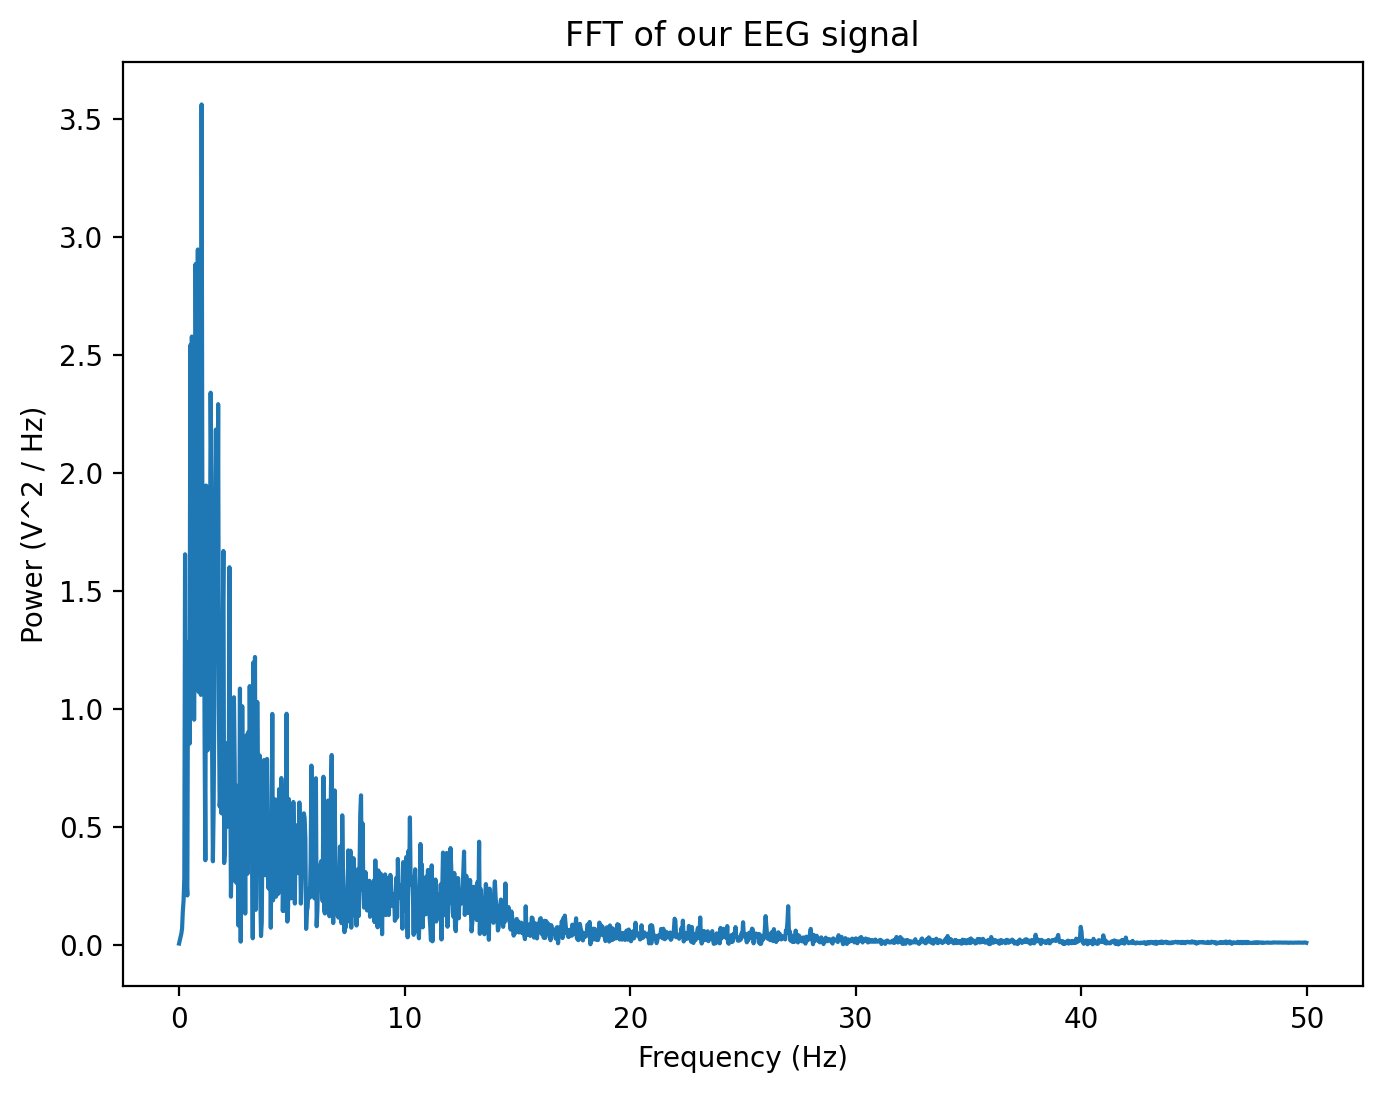

In [29]:
# Calculate the fourier transform of complex signal
ft = np.fft.fft(data)/len(time_vector) # Compute the fft, normalized by time

# Find frequency values for the x axis
nyq = sampling_freq/2 # Determine the nyquist frequency

# Create freq bins for plotting by creating a vector from 0 to nyquist, with as many points as in fft
fx_bins = np.linspace(0,nyq,int(np.floor(len(data)/2))+1)

# plotting up to 200 Hz
plt.figure(figsize=(8, 6))
plt.plot(fx_bins[0:1500],abs(ft[0:1500]))
plt.ylabel('Power (V^2 / Hz)')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of our EEG signal')
plt.show()

Hmm, this is interesting but a bit noisy. Maybe we need a method that is _better_ than the simple fast fourier transform for this type of data. Thankfully, there's a way to smooth out our fft without losing too much information. 

The most widely-used method to do that is [**Welch's Method**](https://en.wikipedia.org/wiki/Welch%27s_method), which consists in averaging consecutive Fourier transform of small windows of the signal, with or without overlapping. Basically, we calculate the fft of a signal across a few sliding windows, and then calculate the mean PSD from all the sliding windows.

The `freqs` vector contains the x-axis (frequency bins) and the `psd` vector contains the y-axis (power spectral density). The units of the power spectral density, when working with EEG data, is usually $\mu$V^2 per Hz.

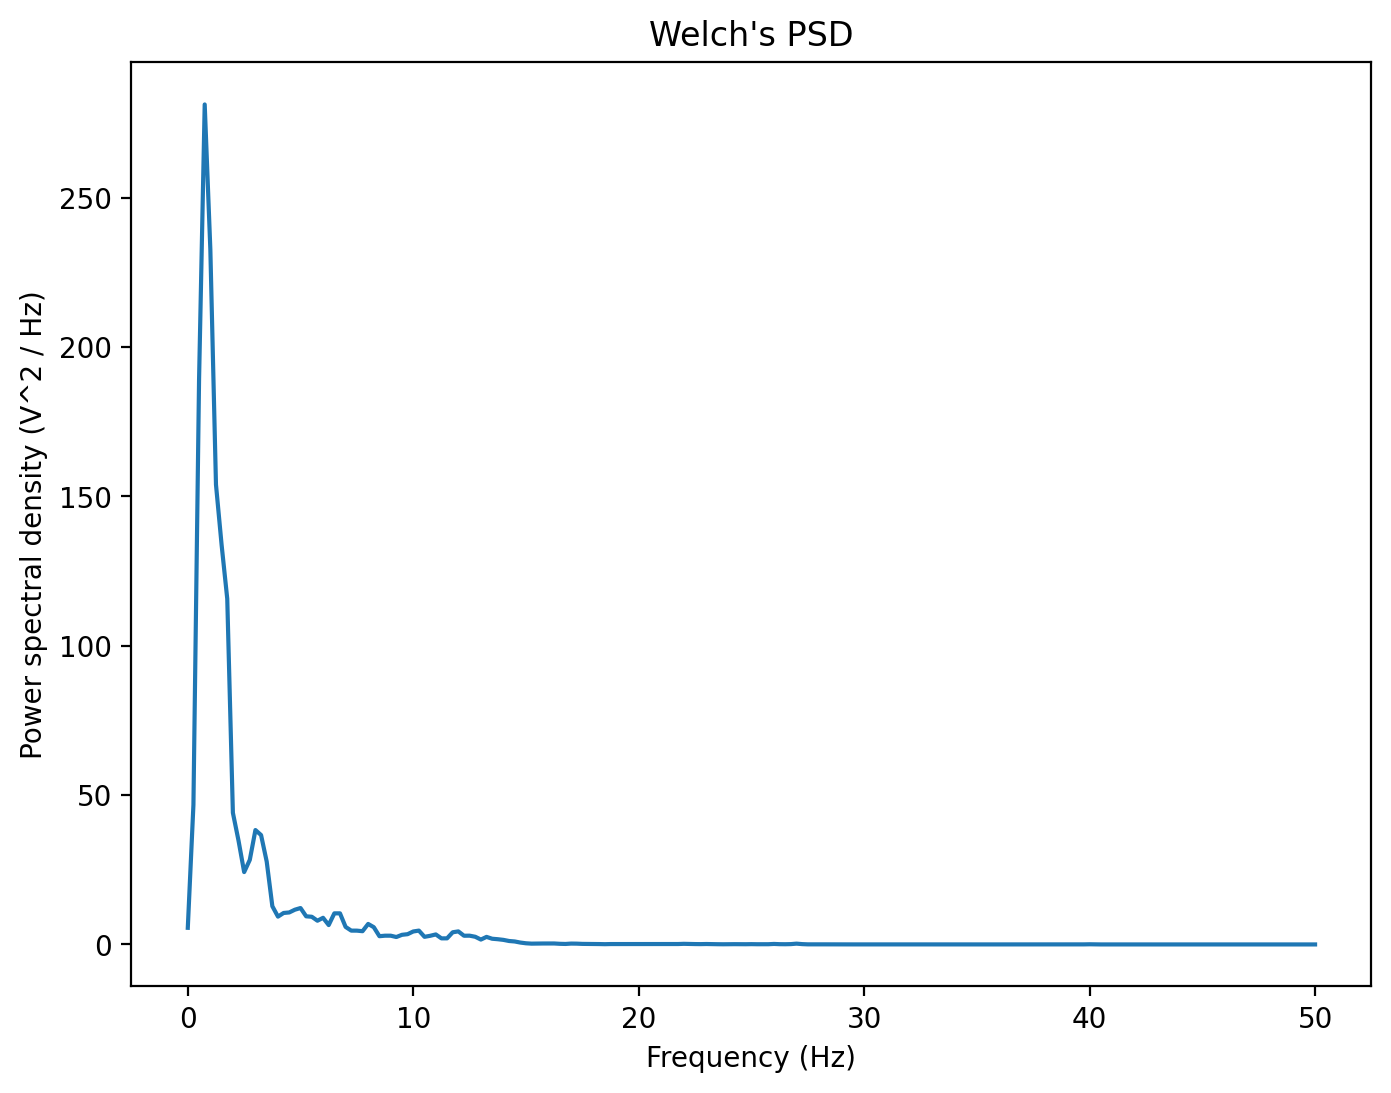

In [30]:
# Define sliding window length (4 seconds, which will give us 2 full cycles at 0.5 Hz)
win = 4 * sampling_freq
freqs, psd = signal.welch(data, sampling_freq, nperseg=win)

# Plot the power spectrum
plt.figure(figsize=(8, 6))
plt.plot(freqs, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.title("Welch's PSD")
plt.show()

That's much easier to interpret! And more importantly, it's computationally sound.

**Note**: Sometimes you'll see these plots in log-log, where both the x and y axes are scaled in log10 units. You can do so with the `plt.loglog()` plotting method (instead of `plt.plot()`) or by using a `ax.set_xscale('log')`.

As a final demonstration, we can plot a spectrogram of our signal. This is a common way to visualize EEG signals. The spectrogram results from doing the FFT on the snippet of the signal that falls into a “window,” plotting the frequency content in the window, then moving the window in time and plotting the frequency content again (and again) until the window has moved across the entire signal.

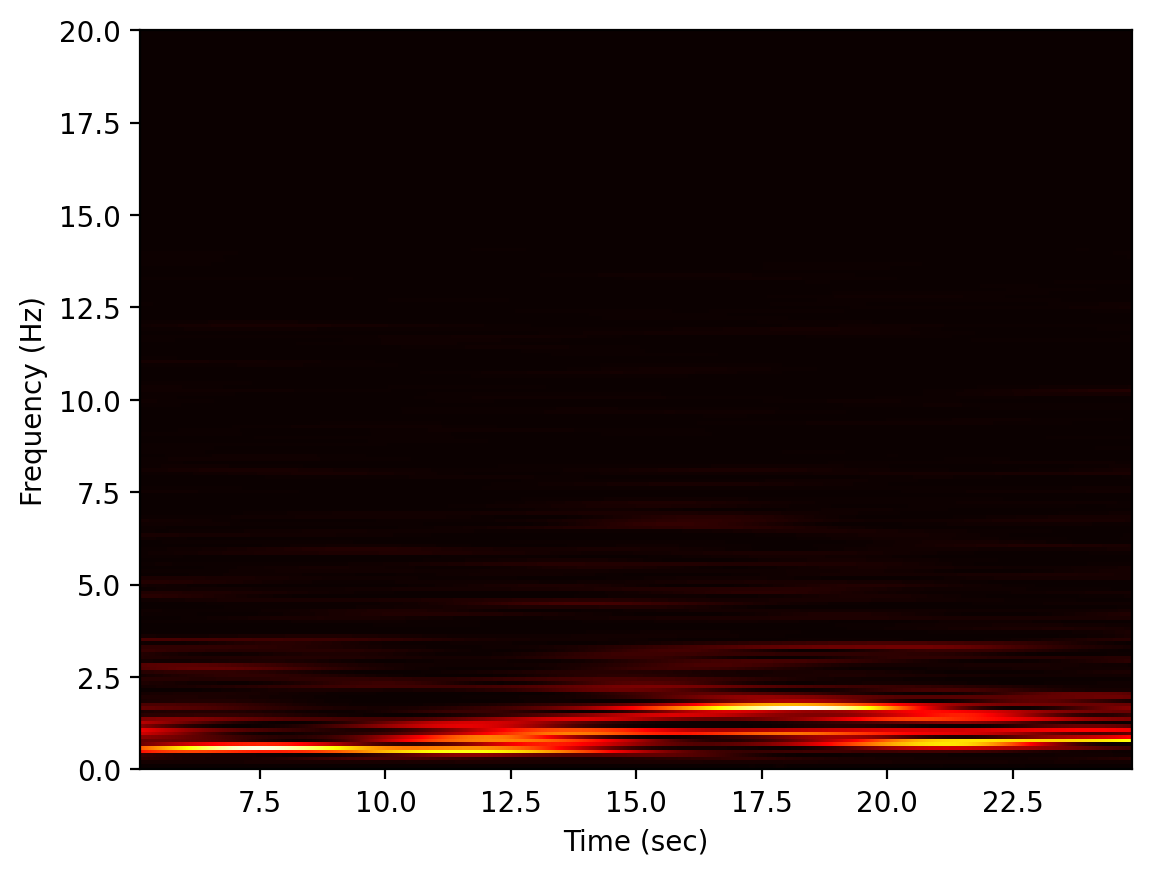

In [96]:
window_size = 1024; # Define the number of elements in our binning window
wind = np.hanning(window_size) # Create a "hanning" window with our given size

# Create the spectrogram and plot

fig = plt.figure() 
f, tt, Sxx = signal.spectrogram(data,sampling_freq,wind,len(wind),len(wind)-1)
plt.pcolormesh(tt,f,Sxx,cmap='hot') #14
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.ylim([0,20])
plt.show()

This isn't particularly interesting -- it's 30 seconds of someone sleeping, after all! But you can clearly see some power in the delta band.

The goal of many labs on campus (and in neuroscience) is to understand the physiological mechanism behind these wavelengths and the shape of the brain's PSD. For example, what factors are correlated with the shapes of the peaks? What are the physiological bases of these peaks?

## About this notebook

Some of the code in this notebook was adapted from [this tutorial](https://raphaelvallat.com/bandpower.html) by Raphael Vallat, [these tutorials](https://github.com/voytekresearch/Tutorials) from Torben Noto, and _Neural Data Science_ by Pascal Wallisch.